In [1]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 26.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (set

In [2]:
!nvidia-smi

Sun Sep  8 14:18:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
import glob


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns

# torch geometrics

import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN

import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader

from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Load graph
view=1
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/content/drive/MyDrive/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [7]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [8]:
# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [9]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [10]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

In [11]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly, so we don't want to
# add them to the graph right away.
# Overall, we can leverage the `RandomLinkSplit()` transform for this from PyG:
from torch_geometric.transforms import RandomLinkSplit
transform = RandomLinkSplit()

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

In [12]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 2365462  Test:675846  Validation: 337922


In [13]:
## EXTERNAL TEST SETS

## VIEW 0-2
#test_sets = ['miRNA-disease2bepred']
#test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.csv", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test.txt",names=["subject","predicate","object"], sep='\t')

In [14]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 12], [True, 16900]]


In [15]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(train_data.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

loader = LinkNeighborLoader(
    train_data,
    num_neighbors=[30] * 2,
    batch_size=128,
)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )

    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

@torch.no_grad()
def get_emb(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return z.cpu().numpy()

best_val_auc = final_test_auc = 0

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [ ]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 243.1308
Epoch: 002, Loss: 85.1481
Epoch: 003, Loss: 45.5326
Epoch: 004, Loss: 57.7188
Epoch: 005, Loss: 65.5011
Epoch: 006, Loss: 55.1814
Epoch: 007, Loss: 39.1965
Epoch: 008, Loss: 27.1301
Epoch: 009, Loss: 20.7684
Epoch: 010, Loss: 17.6848
Epoch: 011, Loss: 15.8716
Epoch: 012, Loss: 14.2792
Epoch: 013, Loss: 12.8360
Epoch: 014, Loss: 11.5074
Epoch: 015, Loss: 10.3663
Epoch: 016, Loss: 9.3483
Epoch: 017, Loss: 8.4679
Epoch: 018, Loss: 7.6759
Epoch: 019, Loss: 7.0107
Epoch: 020, Loss: 6.3722
Epoch: 021, Loss: 5.7498
Epoch: 022, Loss: 5.1389
Epoch: 023, Loss: 4.4661
Epoch: 024, Loss: 3.7772


In [ ]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 3.1320
Epoch: 002, Loss: 2.5633
Epoch: 003, Loss: 2.1138
Epoch: 004, Loss: 1.8150
Epoch: 005, Loss: 1.6549
Epoch: 006, Loss: 1.5989
Epoch: 007, Loss: 1.5967
Epoch: 008, Loss: 1.6066
Epoch: 009, Loss: 1.5973
Epoch: 010, Loss: 1.5629
Epoch: 011, Loss: 1.4927
Epoch: 012, Loss: 1.4077
Epoch: 013, Loss: 1.3205
Epoch: 014, Loss: 1.2319
Epoch: 015, Loss: 1.1507
Epoch: 016, Loss: 1.0749
Epoch: 017, Loss: 1.0078
Epoch: 018, Loss: 0.9476
Epoch: 019, Loss: 0.8950
Epoch: 020, Loss: 0.8527
Epoch: 021, Loss: 0.8199
Epoch: 022, Loss: 0.7951
Epoch: 023, Loss: 0.7784
Epoch: 024, Loss: 0.7662
Epoch: 025, Loss: 0.7578
Epoch: 026, Loss: 0.7522
Epoch: 027, Loss: 0.7469
Epoch: 028, Loss: 0.7416
Epoch: 029, Loss: 0.7373
Epoch: 030, Loss: 0.7327
Epoch: 031, Loss: 0.7286
Epoch: 032, Loss: 0.7251
Epoch: 033, Loss: 0.7223
Epoch: 034, Loss: 0.7196
Epoch: 035, Loss: 0.7179
Epoch: 036, Loss: 0.7161
Epoch: 037, Loss: 0.7143
Epoch: 038, Loss: 0.7125
Epoch: 039, Loss: 0.7106
Epoch: 040, Loss: 0.7084


In [ ]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6886
Epoch: 002, Loss: 0.6876
Epoch: 003, Loss: 0.6869
Epoch: 004, Loss: 0.6862
Epoch: 005, Loss: 0.6855
Epoch: 006, Loss: 0.6851
Epoch: 007, Loss: 0.6847
Epoch: 008, Loss: 0.6843
Epoch: 009, Loss: 0.6838
Epoch: 010, Loss: 0.6837
Epoch: 011, Loss: 0.6832
Epoch: 012, Loss: 0.6829
Epoch: 013, Loss: 0.6826
Epoch: 014, Loss: 0.6824
Epoch: 015, Loss: 0.6822
Epoch: 016, Loss: 0.6820
Epoch: 017, Loss: 0.6819
Epoch: 018, Loss: 0.6817
Epoch: 019, Loss: 0.6816
Epoch: 020, Loss: 0.6815
Epoch: 021, Loss: 0.6814
Epoch: 022, Loss: 0.6814
Epoch: 023, Loss: 0.6814
Epoch: 024, Loss: 0.6812


In [ ]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6811
Epoch: 002, Loss: 0.6811
Epoch: 003, Loss: 0.6811
Epoch: 004, Loss: 0.6810
Epoch: 005, Loss: 0.6810
Epoch: 006, Loss: 0.6809
Epoch: 007, Loss: 0.6808
Epoch: 008, Loss: 0.6808
Epoch: 009, Loss: 0.6807
Epoch: 010, Loss: 0.6807
Epoch: 011, Loss: 0.6806
Epoch: 012, Loss: 0.6806
Epoch: 013, Loss: 0.6806
Epoch: 014, Loss: 0.6804
Epoch: 015, Loss: 0.6805
Epoch: 016, Loss: 0.6804
Epoch: 017, Loss: 0.6804
Epoch: 018, Loss: 0.6803
Epoch: 019, Loss: 0.6801
Epoch: 020, Loss: 0.6802
Epoch: 021, Loss: 0.6802
Epoch: 022, Loss: 0.6801
Epoch: 023, Loss: 0.6800
Epoch: 024, Loss: 0.6800
Epoch: 025, Loss: 0.6800
Epoch: 026, Loss: 0.6799
Epoch: 027, Loss: 0.6799
Epoch: 028, Loss: 0.6799
Epoch: 029, Loss: 0.6798
Epoch: 030, Loss: 0.6798
Epoch: 031, Loss: 0.6797
Epoch: 032, Loss: 0.6797
Epoch: 033, Loss: 0.6797
Epoch: 034, Loss: 0.6796
Epoch: 035, Loss: 0.6796
Epoch: 036, Loss: 0.6796
Epoch: 037, Loss: 0.6795
Epoch: 038, Loss: 0.6795
Epoch: 039, Loss: 0.6795
Epoch: 040, Loss: 0.6794


In [ ]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6791
Epoch: 002, Loss: 0.6791
Epoch: 003, Loss: 0.6791
Epoch: 004, Loss: 0.6790
Epoch: 005, Loss: 0.6790
Epoch: 006, Loss: 0.6790
Epoch: 007, Loss: 0.6790
Epoch: 008, Loss: 0.6789
Epoch: 009, Loss: 0.6789
Epoch: 010, Loss: 0.6789
Epoch: 011, Loss: 0.6788
Epoch: 012, Loss: 0.6788
Epoch: 013, Loss: 0.6787
Epoch: 014, Loss: 0.6788
Epoch: 015, Loss: 0.6787
Epoch: 016, Loss: 0.6788
Epoch: 017, Loss: 0.6788
Epoch: 018, Loss: 0.6787
Epoch: 019, Loss: 0.6787
Epoch: 020, Loss: 0.6786
Epoch: 021, Loss: 0.6786
Epoch: 022, Loss: 0.6785
Epoch: 023, Loss: 0.6785
Epoch: 024, Loss: 0.6785
Epoch: 025, Loss: 0.6784
Epoch: 026, Loss: 0.6784
Epoch: 027, Loss: 0.6784
Epoch: 028, Loss: 0.6783
Epoch: 029, Loss: 0.6784
Epoch: 030, Loss: 0.6783
Epoch: 031, Loss: 0.6783
Epoch: 032, Loss: 0.6782
Epoch: 033, Loss: 0.6783
Epoch: 034, Loss: 0.6782
Epoch: 035, Loss: 0.6782
Epoch: 036, Loss: 0.6782
Epoch: 037, Loss: 0.6782
Epoch: 038, Loss: 0.6781
Epoch: 039, Loss: 0.6780
Epoch: 040, Loss: 0.6781


In [ ]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6778
Epoch: 002, Loss: 0.6778
Epoch: 003, Loss: 0.6777
Epoch: 004, Loss: 0.6777
Epoch: 005, Loss: 0.6777
Epoch: 006, Loss: 0.6776
Epoch: 007, Loss: 0.6777
Epoch: 008, Loss: 0.6776
Epoch: 009, Loss: 0.6775
Epoch: 010, Loss: 0.6775
Epoch: 011, Loss: 0.6775
Epoch: 012, Loss: 0.6775
Epoch: 013, Loss: 0.6775
Epoch: 014, Loss: 0.6773
Epoch: 015, Loss: 0.6775
Epoch: 016, Loss: 0.6773
Epoch: 017, Loss: 0.6774
Epoch: 018, Loss: 0.6773
Epoch: 019, Loss: 0.6772
Epoch: 020, Loss: 0.6772
Epoch: 021, Loss: 0.6773
Epoch: 022, Loss: 0.6772
Epoch: 023, Loss: 0.6772
Epoch: 024, Loss: 0.6771
Epoch: 025, Loss: 0.6771
Epoch: 026, Loss: 0.6771
Epoch: 027, Loss: 0.6771
Epoch: 028, Loss: 0.6771
Epoch: 029, Loss: 0.6771
Epoch: 030, Loss: 0.6769
Epoch: 031, Loss: 0.6770
Epoch: 032, Loss: 0.6770
Epoch: 033, Loss: 0.6770
Epoch: 034, Loss: 0.6769
Epoch: 035, Loss: 0.6768
Epoch: 036, Loss: 0.6768
Epoch: 037, Loss: 0.6769
Epoch: 038, Loss: 0.6767
Epoch: 039, Loss: 0.6768
Epoch: 040, Loss: 0.6767


In [ ]:
# Training
n_epochs=51

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6765
Epoch: 002, Loss: 0.6764
Epoch: 003, Loss: 0.6763
Epoch: 004, Loss: 0.6764
Epoch: 005, Loss: 0.6764
Epoch: 006, Loss: 0.6763
Epoch: 007, Loss: 0.6764
Epoch: 008, Loss: 0.6763
Epoch: 009, Loss: 0.6764
Epoch: 010, Loss: 0.6762
Epoch: 011, Loss: 0.6763
Epoch: 012, Loss: 0.6762
Epoch: 013, Loss: 0.6762
Epoch: 014, Loss: 0.6762
Epoch: 015, Loss: 0.6761
Epoch: 016, Loss: 0.6761
Epoch: 017, Loss: 0.6760
Epoch: 018, Loss: 0.6760
Epoch: 019, Loss: 0.6760
Epoch: 020, Loss: 0.6759
Epoch: 021, Loss: 0.6759
Epoch: 022, Loss: 0.6758
Epoch: 023, Loss: 0.6759
Epoch: 024, Loss: 0.6759
Epoch: 025, Loss: 0.6759
Epoch: 026, Loss: 0.6759
Epoch: 027, Loss: 0.6758
Epoch: 028, Loss: 0.6758
Epoch: 029, Loss: 0.6757
Epoch: 030, Loss: 0.6757
Epoch: 031, Loss: 0.6757
Epoch: 032, Loss: 0.6757
Epoch: 033, Loss: 0.6756
Epoch: 034, Loss: 0.6756
Epoch: 035, Loss: 0.6756
Epoch: 036, Loss: 0.6757
Epoch: 037, Loss: 0.6756
Epoch: 038, Loss: 0.6756
Epoch: 039, Loss: 0.6756
Epoch: 040, Loss: 0.6755


In [ ]:
val_auc = test(val_data)
train_auc = test(train_data)
print(f' View: {view}, Train: {train_auc}, Val: {val_auc:.4f}')

 View: 1, Train: 0.894030120841333, Val: 0.8906


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [16]:
z = get_emb(train_data)

In [17]:
z

array([[-1.6856398e-01, -6.1100498e-02,  1.4800140e-02, ...,
        -7.5366676e-02, -1.3454099e-01, -3.6988296e-02],
       [-4.1976705e+00, -1.5215578e+00,  3.6856097e-01, ...,
        -1.8768222e+00, -3.3504119e+00, -9.2110300e-01],
       [-1.5465102e+00, -5.6057382e-01,  1.3578567e-01, ...,
        -6.9146073e-01, -1.2343625e+00, -3.3935368e-01],
       ...,
       [-1.1830843e+01, -4.2884045e+00,  1.0387635e+00, ...,
        -5.2896934e+00, -9.4429035e+00, -2.5960650e+00],
       [-1.9004709e+01, -6.8887630e+00,  1.6686379e+00, ...,
        -8.4971981e+00, -1.5168800e+01, -4.1702409e+00],
       [-5.4484110e+00, -1.9749217e+00,  4.7837773e-01, ...,
        -2.4360409e+00, -4.3487029e+00, -1.1955557e+00]], dtype=float32)

In [ ]:
y= nodes_df['type'].astype('category').cat.codes

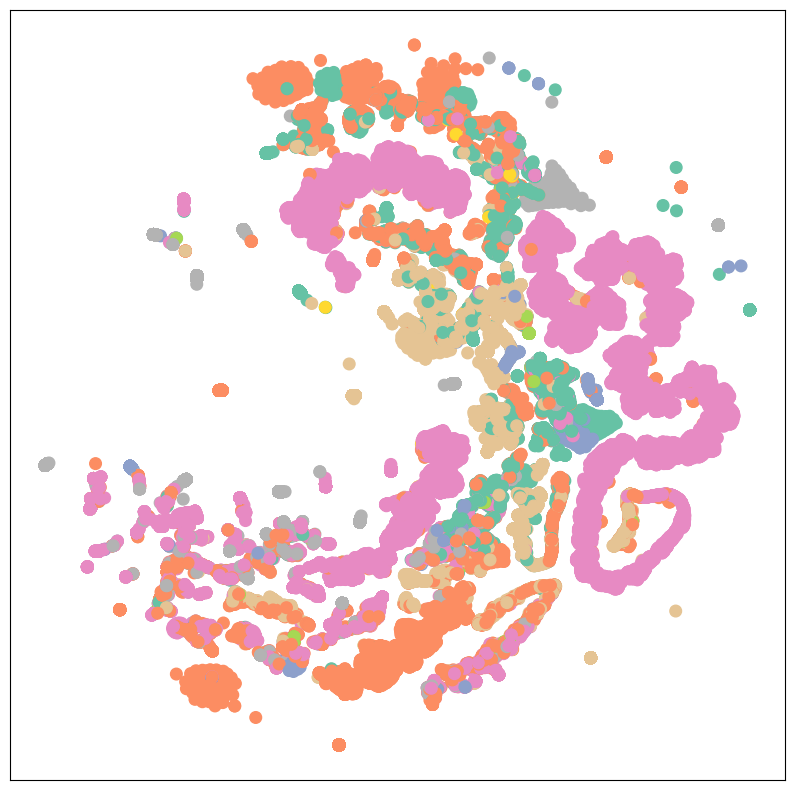

In [ ]:
visualize(z,y)

In [ ]:
torch.save(model, view_path+'GNConv_model_view'+str(view)+'.pth')

In [ ]:
import os

# Define the directory and file path
view =1
view_path = f'/content/drive/MyDrive/VIEW{view}/'
predictions_path = os.path.join(view_path, 'predictions')
file_path = os.path.join(predictions_path, f'view{view}_GNN_node_embeddings.csv')

# Ensure the directory exists
os.makedirs(predictions_path, exist_ok=True)

In [ ]:
probs = edges_to_predict_filtered.copy()
probs['probability']=get_prob(external_test_data)
probs.to_csv(view_path+'predictions/view'+str(view)+'_GNN_node_embeddings.csv')

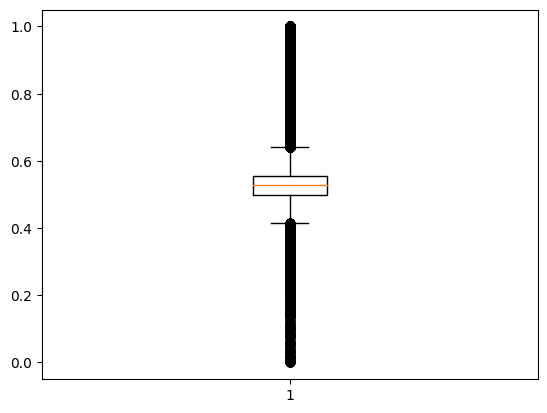

In [ ]:
_=plt.boxplot(get_prob(test_data))

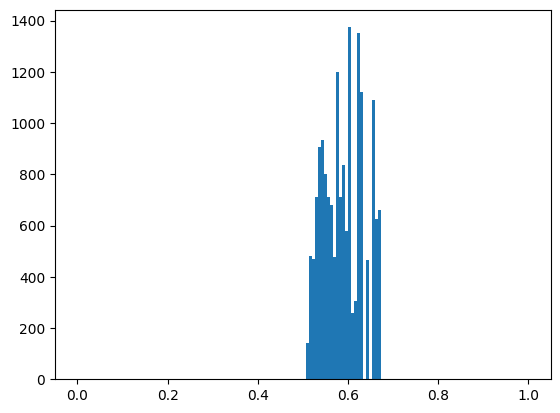

In [ ]:
_=plt.hist(get_prob(external_test_data), bins=150, range=[0,1])

In [18]:
nodes_df

,name,type
0,<http://purl.obolibrary.org/obo/MONDO_0007247>,Disease
1,<https://www.mirbase.org/mature/MIMAT0015042>,miRNA
2,<http://purl.obolibrary.org/obo/UBERON_0002195>,Anatomy
3,<http://purl.obolibrary.org/obo/MONDO_0004583>,Disease
4,<http://purl.obolibrary.org/obo/GO_0060761>,GO
...,...,...
85059,<http://purl.obolibrary.org/obo/MONDO_0010781>,Disease
85060,<http://purl.obolibrary.org/obo/HP_0100454>,Phenotype
85061,<http://www.ncbi.nlm.nih.gov/gene/57101>,Gene
85062,<http://www.ncbi.nlm.nih.gov/gene/51316>,Gene


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = z
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9542
Precision: 0.9541
Recall: 0.9542


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
from grape import Graph
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [20]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)

In [21]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=z,  # Use simplified embedding features
    smoke_test=True,
    enable_cache=False
)

Evaluating on VIEW1_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

In [22]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"_FirstOrderLINE.csv"
results.to_csv(filename)

In [23]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,fowlkes_mallows_index,precision,balanced_accuracy,matthews_correlation_coefficient,negative_likelyhood_ratio,prevalence_threshold,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.800001,1.0,True,0.006565,0.493724,0.499999,-0.000118,1.000002,0.503138,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.800001,1.0,True,0.006152,0.473684,0.499996,-0.000483,1.000009,0.513167,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.800001,1.0,True,0.006310,0.464000,0.499993,-0.000692,1.000013,0.518023,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.800001,1.0,True,0.006789,0.537037,0.500006,0.000662,0.999988,0.481456,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.800001,1.0,True,0.006442,0.463602,0.499993,-0.000715,1.000014,0.518223,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.800001,1.0,True,0.005121,0.369231,0.499975,-0.002565,1.000050,0.566543,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.800001,1.0,True,0.006149,0.415541,0.499982,-0.001768,1.000037,0.542535,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.800001,1.0,True,0.004969,0.379310,0.499979,-0.002236,1.000041,0.561250,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.800001,1.0,True,0.006571,0.478431,0.499996,-0.000419,1.000008,0.510789,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.800001,1.0,True,0.004870,0.348485,0.499970,-0.002995,1.000059,0.577581,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
